In [1]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import numpy as np

# import the necessary libraries
import nltk
import string
import re

from time import time

from gensim.parsing.preprocessing import STOPWORDS
from gensim.utils import simple_preprocess
from sklearn.model_selection import GridSearchCV

from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_sample_weight
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier,LogisticRegression
from sklearn.ensemble import ExtraTreesRegressor
from sklearn import model_selection, svm

import warnings
warnings.filterwarnings('ignore')

C:\Users\Carnival\AppData\Roaming\Python\Python37\site-packages\pandas\compat\_optional.py:138: UserWarning: Pandas requires version '2.7.0' or newer of 'numexpr' (version '2.6.9' currently installed).
  warnings.warn(msg, UserWarning)


### First Let's read our data

In [2]:
df = pd.read_csv('Job titles and industries.csv')

In [3]:
df.head()

,job title,industry
0,technical support and helpdesk supervisor - co...,IT
1,senior technical support engineer,IT
2,head of it services,IT
3,js front end engineer,IT
4,network and telephony controller,IT


In [4]:
df.tail()

,job title,industry
8581,data entry clerk,Marketing
8582,content creator,Marketing
8583,sales & marketing manager,Marketing
8584,marketing & digital marketing consultant,Marketing
8585,creative copywriter (arabic/english),Marketing


### Let's Explore our data to understand it ..

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8586 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  8586 non-null   object
 1   industry   8586 non-null   object
dtypes: object(2)
memory usage: 134.3+ KB


In [6]:
df.describe()

,job title,industry
count,8586,8586
unique,3890,4
top,marketing executive,IT
freq,91,4746


In [7]:

df_count = df['industry'].value_counts().rename_axis('Category').reset_index(name='Count')

In [8]:
df_count.head()

,Category,Count
0,IT,4746
1,Marketing,2031
2,Education,1435
3,Accountancy,374


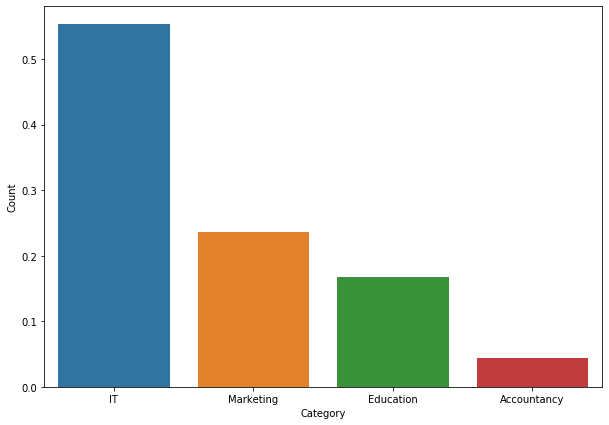

In [9]:
plt.figure(figsize=(10,7))
sns.barplot(x=df_count.Category,y=df_count.Count/len(df))
plt.show()

In [10]:
df_count.Count/len(df)

0    0.552760
1    0.236548
2    0.167133
3    0.043559
Name: Count, dtype: float64

Here there is a Class Less than 5% of existance which is "Accountancy" , So this can be a Way of imbalanced data that can disturb our model .

This is a Problem That should be dealed with before passing our data to a model .

### Let's complete First our EDA for our data . 

#### Let's check first for duplicated rows 

In [11]:
df[df.duplicated()==True]

,job title,industry
7,devops engineers x 3 - global brand,IT
10,devops engineers x 3 - global brand,IT
11,devops engineers x 3 - global brand,IT
26,business analyst,IT
36,.net developer,IT
...,...,...
8572,telesales agent,Marketing
8575,sales manager,Marketing
8576,marketing & social media specialist,Marketing
8580,marketing specialist,Marketing


There are many duplicate rows let's start deal with them through keep one copy of duplicated rows

In [12]:
df.drop_duplicates(subset="job title",inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3890 entries, 0 to 8585
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job title  3890 non-null   object
 1   industry   3890 non-null   object
dtypes: object(2)
memory usage: 91.2+ KB


<Figure size 720x432 with 0 Axes>

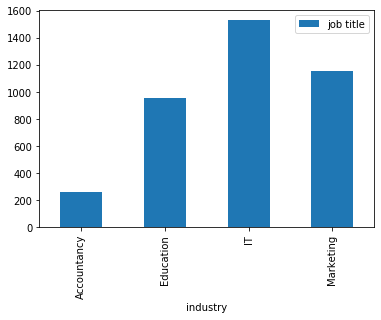

In [14]:
plt.figure(figsize=(10,6))
df.groupby('industry').count().plot.bar()

In [15]:

df_count = df['industry'].value_counts().rename_axis('Category').reset_index(name='Count')

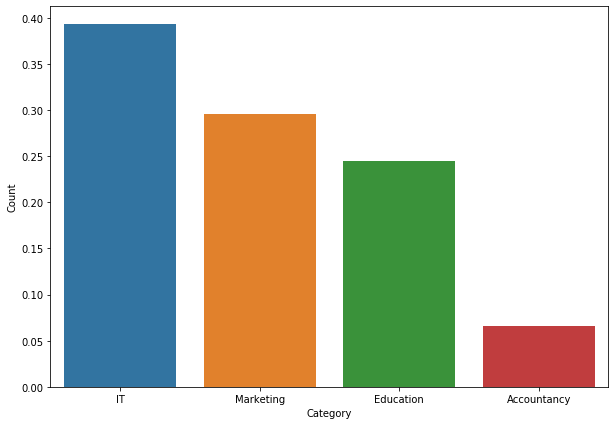

In [16]:
plt.figure(figsize=(10,7))
sns.barplot(x=df_count.Category,y=df_count.Count/len(df))
plt.show()

In [17]:
df_count.Count/len(df)

0    0.392802
1    0.295887
2    0.244987
3    0.066324
Name: Count, dtype: float64

### Let's Deal With text (Text Preprocessing)

This Through : 

1- Remove Stop words Like 'The','and','of',etc...

2- change numerical numbers to text notation

3- Remove Punctiuations:  We remove punctuations so that we don’t have different forms of the same word. If we don’t remove the punctuation, then been. been, been! will be treated separately.

4- Text Lowercase:  to reduce the size of the vocabulary of our text data.

5- Remove White spaces

In [18]:
import inflect
p = inflect.engine()

In [19]:

def Text_Cleaner(text):
    """
        text: a string 
        return: modified clean string
    """
    result = ""
    
    for token in text.split(' '):
        
        if token not in STOPWORDS and len(token) >= 1:
            
            if token.isdigit():
                
                temp = p.number_to_words(token)  #change numerical number to text
                result+=temp+" "
            else:
                
                if not re.match(r'£[0-9]+',  token):  
                    
                    token = token.lower()  #lower case string
                    result+=token+" "     
    translator = str.maketrans('', '', string.punctuation)  #remove punctiuation signs
    return " ".join(result.translate(translator).split())


df['job title'] = df['job title'].map(Text_Cleaner)
df['job title'].head(20)


0     technical support helpdesk supervisor county b...
1                     senior technical support engineer
2                                         head services
3                                       js end engineer
4                          network telephony controller
5                   privileged access management expert
6                 devops engineers x three global brand
8                                         data modeller
9                        php web developer based london
12           solution technical architect ethical brand
13                         lead developer ethical brand
14                            junior frontend developer
15                   vb net web developer milton keynes
16                             data scientist newcastle
17                                   senior bi engineer
18                            machine learning engineer
19                          stack developer oxfordshire
20                   c software developer waltha

### Deal With imbalanced data and pass it to model .. 

Train More Than 1 Model For Text Classification

1- SGD Classifier with Hyper Parameter Tuning 

2- Multi nominal Naive Bayes 

3- Logistic Regression

4- SVM (Support vector machine calssifier)

### hyper parameter tuning for SGDClassifier .

In [20]:

X = df['job title']
y = df['industry']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)
sample_weight = compute_sample_weight("balanced",y_train)

In [21]:
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier()),
])

# uncommenting more parameters will give better exploring power but will
# increase processing time in a combinatorial way
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    'clf__loss': ['log','hinge'],
    'clf__max_iter': (10, 50, 80),
}


# multiprocessing requires the fork to happen in a __main__ protected
# block

# find the best parameters for both the feature extraction and the
# classifier
grid_search = GridSearchCV(pipeline, parameters, n_jobs=-1, verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
print(parameters)
t0 = time()
grid_search.fit(X_train, y_train)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
        print("\t%s: %r" % (param_name, best_parameters[param_name]))

Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'vect__max_df': (0.5, 0.75, 1.0), 'vect__max_features': (None, 5000, 10000, 50000), 'vect__ngram_range': ((1, 1), (1, 2)), 'clf__max_iter': (10, 50, 80), 'clf__alpha': (1e-05, 1e-06), 'clf__penalty': ('l2', 'elasticnet'), 'clf__loss': ['log', 'hinge']}
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
done in 133.897s

Best score: 0.887
Best parameters set:
	clf__alpha: 1e-05
	clf__loss: 'log'
	clf__max_iter: 50
	clf__penalty: 'l2'
	vect__max_df: 0.5
	vect__max_features: 5000
	vect__ngram_range: (1, 1)


In [22]:
make_pipline = Pipeline([('vect', CountVectorizer(max_df=0.5,max_features= 50000,ngram_range= (1, 1))),
               ('tfidf', TfidfTransformer()),
               ('SGD' , SGDClassifier(loss='log', penalty='l2',alpha=1e-05, random_state=42, max_iter=80)),])

make_pipline.fit(X_train, y_train, **{'SGD__sample_weight': sample_weight})

y_pred = make_pipline.predict(X_test)
print('accuracy = {}'.format(accuracy_score(y_pred, y_test)) )

accuracy = 0.8817480719794345


### Naive Bayes

In [23]:
make_pipline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),])

make_pipline.fit(X_train, y_train, **{'clf__sample_weight': sample_weight})

y_pred = make_pipline.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8663239074550129


In [32]:
y_pred 

array(['Marketing', 'IT', 'Marketing', 'Education', 'IT', 'Education',
       'IT', 'IT', 'Education', 'IT', 'Marketing', 'Marketing',
       'Marketing', 'IT', 'IT', 'IT', 'IT', 'Education', 'Marketing',
       'Marketing', 'IT', 'IT', 'Education', 'Education', 'Accountancy',
       'IT', 'Marketing', 'Accountancy', 'IT', 'IT', 'Education',
       'Marketing', 'Marketing', 'Education', 'Marketing', 'Education',
       'Marketing', 'IT', 'Education', 'Marketing', 'Education', 'IT',
       'IT', 'IT', 'IT', 'Accountancy', 'Education', 'Accountancy', 'IT',
       'IT', 'Marketing', 'IT', 'Marketing', 'Marketing', 'Marketing',
       'IT', 'Marketing', 'IT', 'Accountancy', 'IT', 'IT', 'IT',
       'Education', 'IT', 'Accountancy', 'Marketing', 'IT', 'Marketing',
       'Marketing', 'IT', 'Marketing', 'Marketing', 'Marketing',
       'Education', 'IT', 'Education', 'IT', 'Accountancy', 'Marketing',
       'IT', 'Marketing', 'Education', 'IT', 'Education', 'Accountancy',
       'Accountancy

### Logistic Regression

In [24]:
make_pipline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('log' , LogisticRegression(n_jobs=1, C=1e5)),])

make_pipline.fit(X_train, y_train, **{'log__sample_weight': sample_weight})

y_pred = make_pipline.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))

accuracy 0.8496143958868895


### Support Vector Machine

In [25]:
make_pipline = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto',probability=True)),])

make_pipline.fit(X_train, y_train, **{'clf__sample_weight': sample_weight})

y_pred = make_pipline.predict(X_test)
print('accuracy %s' % accuracy_score(y_pred, y_test))


accuracy 0.890745501285347


In [26]:
X_test.to_csv('out.csv', index=False) 

### Confusion Matrix for the final model Used SVM 

In [27]:
a = np.flip(df['industry'].unique())

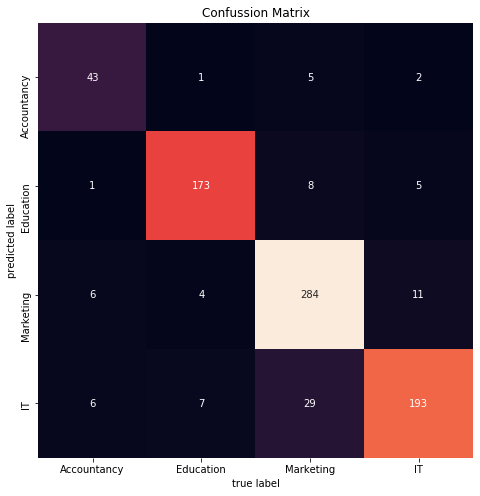

In [28]:
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,8))
ax = sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=a, yticklabels=a)
bottom, top = ax.get_ylim()
ax.set_ylim(bottom + 0.5, top - 0.5)

plt.title('Confussion Matrix')
plt.xlabel('true label')
plt.ylabel('predicted label');

IT is the highest class which missed it's labels , while it appeares that Marketing and education missed the leaset

In [29]:
from sklearn import metrics 
print(metrics.classification_report(y_test, y_pred, target_names=a))


              precision    recall  f1-score   support

 Accountancy       0.84      0.77      0.80        56
   Education       0.93      0.94      0.93       185
   Marketing       0.93      0.87      0.90       326
          IT       0.82      0.91      0.87       211

    accuracy                           0.89       778
   macro avg       0.88      0.87      0.87       778
weighted avg       0.89      0.89      0.89       778



The performance measurment prove our thoughts from confusion matrix as the marketing and education are the highest classes with true positive rate precision that for classes that are marketing or education and they are classified as marketing or education
while Accountancy have the leaset true positive rate 

In [30]:
metrics.roc_auc_score(y_test, make_pipline.predict_proba(X_test), multi_class='ovr')

0.97225024639591

The Area Under the Receiver Operating Characteristic Curve (AUC) is between 0.5 to 1 which 1 denates the out standing performance of the model, 0.5 the opposite , here 0.97 is a very good score that indicates that our model performance is very good .

### Deploy model as RESTFul Api Service

In [31]:
# import pickle
# pickle.dump(make_pipline, open('final_prediction.pickle', 'wb'))